In [7]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# def extract_mel_spectrogram(file_path, n_mels=128, hop_length=512, fixed_length=40, sr=22050):
#     y, sr = librosa.load(file_path, duration=0.5, sr=sr)  # 加載1.0秒音訊，固定採樣率
#     # 確保音訊長度固定，pad 或 truncate
#     y = librosa.util.fix_length(y, size=int(sr * 0.5))
#     mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
#     mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
#     # 檢查時間步數，並進行填充或截斷
#     if mel_spec_db.shape[1] < fixed_length:
#         pad_width = fixed_length - mel_spec_db.shape[1]
#         mel_spec_db = np.pad(mel_spec_db, pad_width=((0,0), (0, pad_width)), mode='constant')
#     else:
#         mel_spec_db = mel_spec_db[:, :fixed_length]
    
#     return mel_spec_db

def extract_mel_spectrogram(file_path, n_mels=128, hop_length=512, fixed_length=32, sr=22050):
    y, sr = librosa.load(file_path, duration=0.5, sr=sr)  # 加載0.5秒音訊，固定採樣率
    # 確保音訊長度固定，pad 或 truncate
    y = librosa.util.fix_length(y, size=int(sr * 0.5))
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # 檢查時間步數，並進行填充或截斷
    if mel_spec_db.shape[1] < fixed_length:
        pad_width = fixed_length - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, pad_width=((0,0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :fixed_length]
    
    # 重塑或插值至32x32
    mel_image = Image.fromarray(mel_spec_db)
    mel_image = mel_image.resize((128, 32))  # (width, height)
    mel_spec_db = np.array(mel_image)
    
    return mel_spec_db


In [8]:
import pandas as pd

def create_dataset(swallow_dir, non_dir, n_mels=128, hop_length=512, fixed_length=40, sr=22050):
    data = []
    labels = []
    
    # 加載吞嚥聲音檔案
    for file in os.listdir(swallow_dir):
        if file.endswith('.wav'):
            file_path = os.path.join(swallow_dir, file)
            try:
                mel = extract_mel_spectrogram(file_path, n_mels=n_mels, hop_length=hop_length, fixed_length=fixed_length, sr=sr)
                data.append(mel)
                labels.append(1)
            except Exception as e:
                print(f"處理文件 {file_path} 時出現錯誤: {e}")
    
    # 加載非吞嚥聲音檔案
    for file in os.listdir(non_dir):
        if file.endswith('.wav'):
            file_path = os.path.join(non_dir, file)
            try:
                mel = extract_mel_spectrogram(file_path, n_mels=n_mels, hop_length=hop_length, fixed_length=fixed_length, sr=sr)
                data.append(mel)
                labels.append(0)
            except Exception as e:
                print(f"處理文件 {file_path} 時出現錯誤: {e}")
    
    return np.array(data), np.array(labels)

# def create_dataset(swallow_dir, non_dir, n_mels=128, hop_length=512, fixed_length=32, sr=22050):
#     data = []
#     labels = []
    
#     # 加載吞嚥聲音檔案
#     for file in os.listdir(swallow_dir):
#         if file.endswith('.wav'):
#             file_path = os.path.join(swallow_dir, file)
#             try:
#                 mel = extract_mel_spectrogram(file_path, n_mels=n_mels, hop_length=hop_length, fixed_length=fixed_length, sr=sr)
#                 data.append(mel)
#                 labels.append(1)
#             except Exception as e:
#                 print(f"處理文件 {file_path} 時出現錯誤: {e}")
    
#     # 加載非吞嚥聲音檔案
#     for file in os.listdir(non_dir):
#         if file.endswith('.wav'):
#             file_path = os.path.join(non_dir, file)
#             try:
#                 mel = extract_mel_spectrogram(file_path, n_mels=n_mels, hop_length=hop_length, fixed_length=fixed_length, sr=sr)
#                 data.append(mel)
#                 labels.append(0)
#             except Exception as e:
#                 print(f"處理文件 {file_path} 時出現錯誤: {e}")
    
#     return np.array(data), np.array(labels)

# 定義資料夾路徑
swallow_dir = 'split05/swallow'  # 替換為實際路徑
non_dir = 'split05/non'          # 替換為實際路徑
# 建立資料集
X, y = create_dataset(swallow_dir, non_dir)
print(f"資料集大小: {X.shape}, 標籤大小: {y.shape}")  # 應為 (num_samples, 128, 40)


資料集大小: (112, 32, 128), 標籤大小: (112,)


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 固定的參數
n_mels = 128
fixed_length = 32

# 標準化
# scaler = StandardScaler()
# X_reshaped = X.reshape(X.shape[0], -1)  # 將每個頻譜圖展平成一維 (num_samples, 128*40=5120)
# X_scaled = scaler.fit_transform(X_reshaped)  # (num_samples, 5120)

# # 重塑為 (num_samples, 40, 128, 1)
# X_scaled = X_scaled.reshape(X.shape[0], fixed_length, n_mels, 1)

# # 複製通道以符合 ResNet50 的輸入要求 (num_samples, 40, 128, 3)
# X_scaled = np.repeat(X_scaled, 3, axis=-1)  # 現在形狀為 (num_samples, 40, 128, 3)

# # 拆分訓練集和驗證集
# X_train, X_val, y_train, y_val = train_test_split(
#     X_scaled, y, test_size=0.2, random_state=42, stratify=y
# )
# print(f"訓練集大小: {X_train.shape}, 驗證集大小: {X_val.shape}")  # 應為 (num_train, 40, 128, 3), (num_val,)

# 標準化
scaler = StandardScaler()
X_reshaped = X.reshape(X.shape[0], -1)  # 將每個頻譜圖展平成一維 (num_samples, 32*128=4096)
X_scaled = scaler.fit_transform(X_reshaped)  # (num_samples, 4096)

# 重塑為 (num_samples, 32, 128, 1)
X_scaled = X_scaled.reshape(X.shape[0], 32, 128, 1)

# 複製通道以符合 ResNet50 的輸入要求 (num_samples, 32, 128, 3)
X_scaled = np.repeat(X_scaled, 3, axis=-1)  # 現在形狀為 (num_samples, 32, 128, 3)

# 拆分訓練集和驗證集
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print(f"訓練集大小: {X_train.shape}, 驗證集大小: {X_val.shape}")  # 應為 (num_train, 32, 128, 3), (num_val,)



訓練集大小: (89, 32, 128, 3), 驗證集大小: (23, 32, 128, 3)


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

def build_model(input_shape):
    # 使用 ResNet50 作為基礎模型，不包括頂層
    resnet = ResNet50(weights=None, include_top=False, input_shape=input_shape)
    resnet.trainable = True  # 根據需求設定是否訓練 ResNet 層
    
    model = models.Sequential()
    model.add(resnet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Reshape((1, -1)))  # 為 LSTM 準備序列格式
    model.add(layers.LSTM(64, return_sequences=False))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

input_shape = (fixed_length, n_mels, 3)  # 例如 (40, 128, 3)
model = build_model(input_shape)

In [16]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 1, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 2048)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,128,705 (92.04 MB)

 Trainable params: 24,075,585 (91.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 861ms/step - accuracy: 0.4928 - loss: 0.8494 - val_accuracy: 0.5652 - val_loss: 0.6719
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 317ms/step - accuracy: 0.5907 - loss: 0.6753 - val_accuracy: 0.5652 - val_loss: 0.6713
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 329ms/step - accuracy: 0.7687 - loss: 0.5996 - val_accuracy: 0.5652 - val_loss: 0.6630
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step - accuracy: 0.8354 - loss: 0.5353 - val_accuracy: 0.5652 - val_loss: 0.6595
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.8982 - loss: 0.3974 - val_accuracy: 0.6957 - val_loss: 0.6562
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 281ms/step - accuracy: 0.8723 - loss: 0.3891 - val_accuracy: 0.6087 - val_loss: 0.6674
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.8930 - loss: 0.3673 - val_accuracy: 0.5652 - val_loss: 0.6547
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step - accuracy: 0.8510 - loss: 0.3602 - val_accuracy: 0.5652 - val_loss

c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 28310 (\N{CJK UNIFIED IDEOGRAPH-6E96}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25613 (\N{CJK UNIFIED IDEOGRAPH-640D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bymin\anaconda3\envs\swallow\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 22833

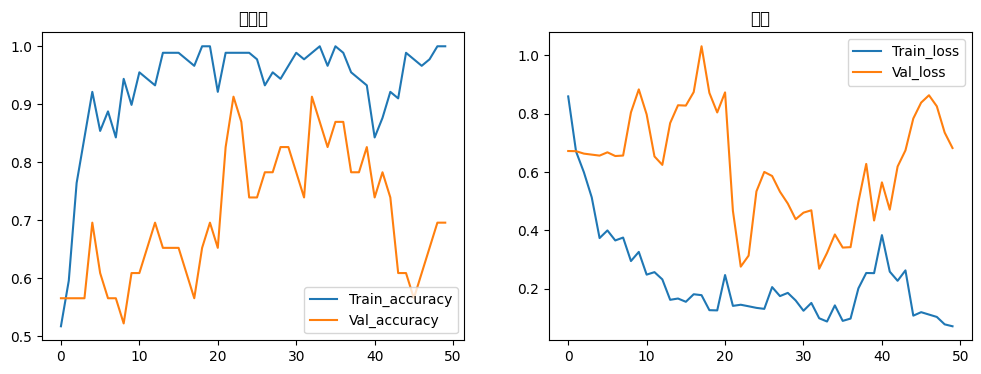

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    ]
)

import matplotlib.pyplot as plt
# 繪製訓練與驗證的準確率
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train_accuracy')
plt.plot(history.history['val_accuracy'], label='Val_accuracy')
plt.legend()
plt.title('準確率')

# 繪製訓練與驗證的損失
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Val_loss')
plt.legend()
plt.title('損失')
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
混淆矩陣:
[[11  2]
 [ 0 10]]
分類報告:
              precision    recall  f1-score   support

 Non-Swallow       1.00      0.85      0.92        13
     Swallow       0.83      1.00      0.91        10

    accuracy                           0.91        23
   macro avg       0.92      0.92      0.91        23
weighted avg       0.93      0.91      0.91        23



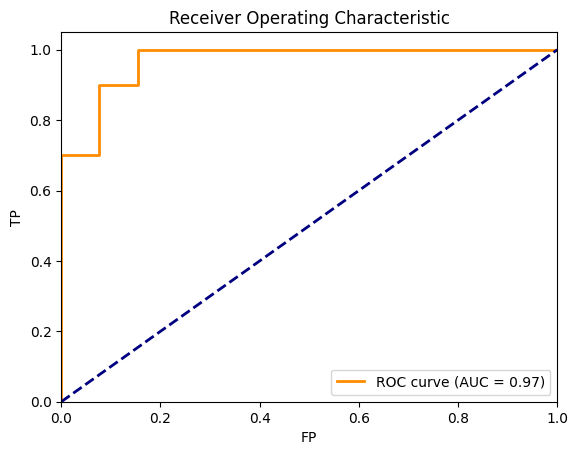

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

# 在驗證集上進行預測
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)
# 混淆矩陣
cm = confusion_matrix(y_val, y_pred)
print("混淆矩陣:")
print(cm)
# 分類報告
cr = classification_report(y_val, y_pred, target_names=['Non-Swallow', 'Swallow'])
print("分類報告:")
print(cr)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP')
plt.ylabel('TP')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



In [ ]:
import pyaudio
import numpy as np
import librosa

def real_time_detection(model, scaler, n_mels=128, hop_length=512, fixed_length=40, sr=22050):
    CHUNK = int(sr * 0.5)  # 1.0秒的音訊
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = sr

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("開始實時監聽... 按 Ctrl+C 停止")

    try:
        while True:
            data = stream.read(CHUNK, exception_on_overflow=False)
            y = np.frombuffer(data, dtype=np.int16).astype(np.float32)
            # 確保音訊長度固定
            y = librosa.util.fix_length(y, size=CHUNK)
            mel_spec = librosa.feature.melspectrogram(y=y, sr=RATE, n_mels=n_mels, hop_length=hop_length)
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            # 填充或截斷
            if mel_spec_db.shape[1] < fixed_length:
                pad_width = fixed_length - mel_spec_db.shape[1]
                mel_spec_db = np.pad(mel_spec_db, pad_width=((0,0), (0, pad_width)), mode='constant')
            else:
                mel_spec_db = mel_spec_db[:, :fixed_length]
            # 標準化
            mel_spec_db = scaler.transform(mel_spec_db.reshape(1, -1)).reshape(mel_spec_db.shape)
            # 調整形狀
            mel_spec_db = mel_spec_db.reshape(1, fixed_length, n_mels, 1)
            mel_spec_db = np.repeat(mel_spec_db, 3, axis=-1)  # 複製通道以符合模型要求
            # 預測
            prediction = model.predict(mel_spec_db)
            if prediction > 0.7:
                print("檢測到吞嚥聲")
    except KeyboardInterrupt:
        print("停止實時監聽")
    finally:
        stream.stop_stream()
        stream.close()
        p.terminate()

# 啟動實時檢測（取消註解以下行以運行）
# real_time_detection(model, scaler)


In [23]:
def count_swallowing(file_path, model, scaler, n_mels=128, hop_length=512, fixed_length=32, sr=22050):
    y, sr = librosa.load(file_path, duration=30, sr=sr)
    chunk_length = int(sr * 0.5)  # 1.0秒
    count = 0
    for i in range(0, len(y), chunk_length):
        chunk = y[i:i+chunk_length]
        if len(chunk) < chunk_length:
            # 填充
            chunk = librosa.util.fix_length(chunk, size=chunk_length)
        mel_spec = librosa.feature.melspectrogram(y=chunk, sr=sr, n_mels=n_mels, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        # 填充或截斷
        if mel_spec_db.shape[1] < fixed_length:
            pad_width = fixed_length - mel_spec_db.shape[1]
            mel_spec_db = np.pad(mel_spec_db, pad_width=((0,0), (0, pad_width)), mode='constant')
        else:
            mel_spec_db = mel_spec_db[:, :fixed_length]
        # 標準化
        mel_spec_db = scaler.transform(mel_spec_db.reshape(1, -1)).reshape(mel_spec_db.shape)
        # 調整形狀
        mel_spec_db = mel_spec_db.reshape(1, fixed_length, n_mels, 1)
        mel_spec_db = np.repeat(mel_spec_db, 3, axis=-1)  # 複製通道
        # 預測
        prediction = model.predict(mel_spec_db)
        if prediction > 0.5:
            count += 1
    return count

# 範例用法
file_path = '音檔\語音 014.wav'  # 替換為實際路徑
num_swallow = count_swallowing(file_path, model, scaler)
print(f"吞嚥聲數量: {num_swallow}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━